1. Download and install the project

In [2]:
!git clone https://github.com/peculab/DFTDescriptorPipeline.git
%cd DFTDescriptorPipeline
!pip install -r requirements.txt

Cloning into 'DFTDescriptorPipeline'...
remote: Enumerating objects: 28, done.
remote: Counting objects: 100% (28/28), done.
remote: Compressing objects: 100% (13/13), done.
remote: Total 28 (delta 13), reused 25 (delta 13), pack-reused 0 (from 0)
Receiving objects: 100% (28/28), 4.30 MiB | 10.67 MiB/s, done.
Resolving deltas: 100% (13/13), done.
/content/DFTDescriptorPipeline/DFTDescriptorPipeline
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.5/133.5 kB 2.3 MB/s eta 0:00:00
  Attempting uninstall: jupyter-client
    Found existing installation: jupyter_client 8.6.3
    Uninstalling jupyter_client-8.6.3:
      Successfully uninstalled jupyter_client-8.6.3


2. (Optional) List the files to confirm the existence of the log file

In [3]:
!ls logfiles/

H.log	  m-OMe.log    o-CF3.log  o-F.log    o-Me.log	o-Ph.log  p-CO2Me.log
m-CN.log  m-SO2Me.log  o-Cl.log   o-iPr.log  o-OMe.log	p-Cl.log


3. Load the package and enable custom modules

In [4]:
import sys
sys.path.append(".")

from descriptors.extractor import extract_homo_lumo, extract_dipole_moment, extract_polarizability
from descriptors.sterimol import find_oh_bonds, find_c1_c2

R²: 1.000
Coefficients: {'HOMO': np.float64(-0.9999999999999781), 'LUMO': np.float64(1.0000000000000298), 'Dipole': np.float64(-9.159339953157541e-16), 'Polarizability': np.float64(0.0)}


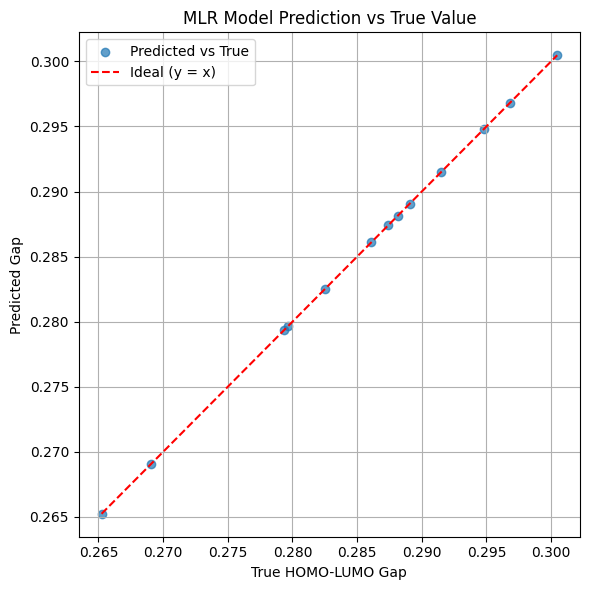

In [6]:
import pandas as pd
import os
from descriptors.extractor import *
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt

# Step 1: Capture all log file data
log_dir = "logfiles"
results = []

for file in os.listdir(log_dir):
    if file.endswith(".log"):
        path = os.path.join(log_dir, file)
        homo, lumo = extract_homo_lumo(path)
        dipole = extract_dipole_moment(path)
        polar = extract_polarizability(path)
        results.append({
            "Molecule": file.replace(".log", ""),
            "HOMO": homo,
            "LUMO": lumo,
            "Dipole": dipole,
            "Polarizability": polar
        })

df = pd.DataFrame(results).dropna()
df["Gap"] = df["LUMO"] - df["HOMO"]

# Step 2: Build the model
X = df[["HOMO", "LUMO", "Dipole", "Polarizability"]]
y = df["Gap"]

model = LinearRegression()
model.fit(X, y)
pred = model.predict(X)

# Step 3: Display regression results
r2 = model.score(X, y)
print(f"R²: {r2:.3f}")
print("Coefficients:", dict(zip(X.columns, model.coef_)))

# Step 4: Draw the image
plt.figure(figsize=(6,6))
plt.scatter(y, pred, label="Predicted vs True", alpha=0.7)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', label="Ideal (y = x)")
plt.xlabel("True HOMO-LUMO Gap")
plt.ylabel("Predicted Gap")
plt.title("MLR Model Prediction vs True Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()